# Notebook to apply Deep Qlearning to Atari boxing
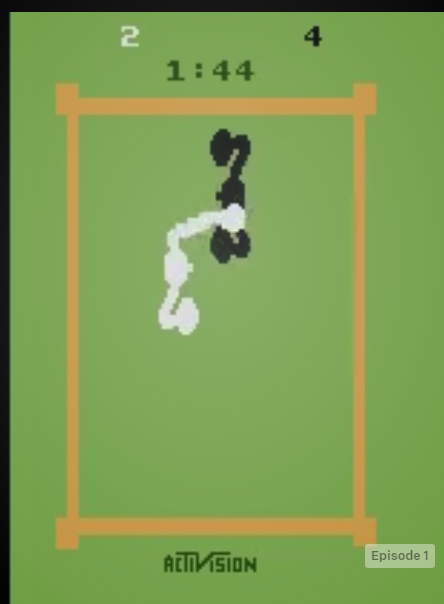

# Wrappers
1. skipframe
2. greyscale
3. focus and resize
4. stackframe

In [1]:
#environment wrappers
import gym
import numpy as np
import torchvision.transforms as T
from gym.spaces import Box
from gym.wrappers import FrameStack
import torch
import time
from PIL import Image

class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip
        
    def step(self, action):
        total_reward = 0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward+=reward
            if done:
                break
            
        return obs, total_reward, done, info
    
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)


    def observation(self, observation):
        observation = observation[:, :, 0] * 0.299 + observation[:, :, 1] * 0.587 + observation[:, :, 2] * 0.114
        return observation/255.0
    
class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape, crop=None):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape=(shape, shape)
        else:
            self.shape=tuple(shape)
        
        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space=Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)
        self.crop = crop
        
    def observation(self,observation):
        observation = observation[self.crop[0]:-self.crop[0], self.crop[1]:-self.crop[1]]
        #transforms = T.Compose(
        #    [T.Resize(self.shape), T.Normalize(0, 255)]
        #)
        #observation = transforms(observation)
        img = Image.fromarray(observation)
        img2 = img.resize(self.shape, Image.NEAREST)
        return np.asarray(img2)
                         
class ArrayFromObs(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = env.observation_space
    def observation(self, observation):
        return torch.tensor(observation.__array__(), dtype=torch.float)
    
def showimagetensor(t):
    im = Image.fromarray(np.uint8(t.numpy()*255))
    im.show()
    
skipframe = 4
env = gym.make("BoxingNoFrameskip-v4")
env = SkipFrame(env, skipframe)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84, crop=[30, 30])
env = FrameStack(env, num_stack=skipframe)
env = ArrayFromObs(env)
env.reset()
t1 = time.time()
total_reward=0
frames = 0
while True:
    obs, reward, done, _ = env.step(env.action_space.sample())
    total_reward+=reward
    #print(obs.shape, reward, done)
    frames+=1
    if done:
        break
print(total_reward)
t2 = time.time()
print(t2-t1)
#print((obs[0]-obs[1]).norm())
print(f"frames in episode:{frames}")
print(env.reset())

-2.0
5.442270755767822
frames in episode:1786
tensor([[[0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874],
         [0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874],
         [0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874],
         ...,
         [0.5874, 0.5874, 0.5176,  ..., 0.5176, 0.5874, 0.5874],
         [0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874],
         [0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874]],

        [[0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874],
         [0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874],
         [0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874],
         ...,
         [0.5874, 0.5874, 0.5176,  ..., 0.5176, 0.5874, 0.5874],
         [0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874],
         [0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874]],

        [[0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874],
         [0.5874, 0.5874, 0.5874,  ..., 0.5874, 0.5874, 0.5874],
         [0.

In [10]:
showimagetensor(obs[3])
print(obs.shape)

torch.Size([4, 84, 84])


## After wrappers:
1. state is a (n, 84, 84) pytorch tensor
2. Example of a state with n=2 shown below
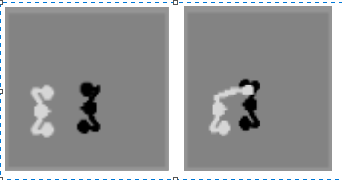

# Define network to be used

In [2]:
import math
import torch.nn as nn
import torch.nn.functional as F

class NoisyLinear(nn.Linear):
    """
    Implements noisy linear layer. 
    taken from: https://github.com/Shmuma/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter07/lib/dqn_model.py
    
    """
    def __init__(self, in_features, out_features, sigma_init=0.018, bias=True):
        super(NoisyLinear, self).__init__(in_features, out_features, bias=bias)
        self.sigma_weight = nn.Parameter(torch.full((out_features, in_features), sigma_init))
        self.register_buffer("epsilon_weight", torch.zeros(out_features, in_features))
        if bias:
            self.sigma_bias = nn.Parameter(torch.full((out_features,), sigma_init))
            self.register_buffer("epsilon_bias", torch.zeros(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        std = math.sqrt(3 / self.in_features)
        self.weight.data.uniform_(-std, std)
        self.bias.data.uniform_(-std, std)

    def forward(self, input):
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self.sigma_bias * self.epsilon_bias.data
        return F.linear(input, self.weight + self.sigma_weight * self.epsilon_weight.data, bias)

    
class BoxerBasicNet(nn.Module):
    """
    A basic convolutional network to use in DQN
    """
    
    def __init__(self, input_shape, output_shape):
        super(BoxerBasicNet, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
    
        out_size = self._get_conv_out(input_shape)
    
        self.classifier = nn.Sequential(
            nn.Linear(out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_shape)
        )
    
        
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
class BoxerNoisyNet(nn.Module):
    """
    A convolutional network to use in DQN
    with noisy linear layers
    """
    
    def __init__(self, input_shape, output_shape):
        super(BoxerNoisyNet, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
    
        out_size = self._get_conv_out(input_shape)
    
        self.classifier = nn.Sequential(
            NoisyLinear(out_size, 512),
            nn.ReLU(),
            NoisyLinear(512, output_shape)
        )
    
        
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
    
class DuelingBoxerNoisyNet(nn.Module):
    """
    A convolutional network to use in DQN
    with noisy linear layers
    """
    
    def __init__(self, input_shape, output_shape):
        super(DuelingBoxerNoisyNet, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
    
        out_size = self._get_conv_out(input_shape)
    
        self.adv = nn.Sequential(
            NoisyLinear(out_size, 512),
            nn.ReLU(),
            NoisyLinear(512, output_shape)
        )
        
        self.val = nn.Sequential(
            NoisyLinear(out_size, 512),
            nn.ReLU(),
            NoisyLinear(512, 1)
        )
    
        
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        val = self.val(x)
        adv = self.adv(x)
        return val+adv-adv.mean()
        return x
    
net = DuelingBoxerNoisyNet((4,84,84), 18)
net(torch.randn(1,4,84,84)).shape


torch.Size([1, 18])

In [3]:
from collections import namedtuple, deque
import random
ActionPair = namedtuple('ActionPair', ('state','action','next_state', 'reward'))

class ReplayBuffer:
    
    def __init__(self, capacity):
        
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        
    def push(self, ActionPair):
        #print(len(self.buffer))
        self.buffer.append(ActionPair)
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)
    
    def __repr__(self):
        return f"ReplayBuffer {len(self.buffer)}/{self.capacity}"

In [4]:
# Agent logic from previous notebook

import math

class BoxerAgent:
    
    def __init__(self, capacity=10000, eps=0.9, gamma=0.99, lr=0.0005, dqn_steps=1, doubleQ=False, device="cpu", threshold=10000):
        
        
        self.steps_done = 0
        
        self.device = device
        
        self.eps_start = eps
        self.eps_end = 0.01
        self.eps_decay = 150000
        self.gamma = gamma 
        
        #self.net =  LunarNet(8, 128, 4).to(device) 
        #self.target_net =  LunarNet(8, 128, 4).to(device)
        #self.target_net.load_state_dict(self.net.state_dict())
        
        # Noisy variants
        self.net =  DuelingBoxerNoisyNet((4,84,84), 18).to(device) 
        self.target_net = DuelingBoxerNoisyNet((4,84,84), 18).to(device)
        self.target_net.load_state_dict(self.net.state_dict())
        
        
        #self.target_net.eval()
        
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
        self.memory = ReplayBuffer(capacity)
        self.dqn_steps = dqn_steps
        
        self.doubleQ = doubleQ
    
        self.train_threshold = threshold
        
        
    def sync_nets(self):
        self.target_net.load_state_dict(self.net.state_dict())
        return
    
    def act(self, state, env):
        """
           
        takes as input a state and computes action
        adds ActionPair to memory
        returns is_done, reward and next state
        """
        #print(state.shape)
        # add epsilon-greedy later
        sample = random.random()
        
        #eps_threshold = self.eps_end + (self.eps_start-self.eps_end)*math.exp(-1.*self.steps_done/self.eps_decay)
        #noisy nets
        eps_threshold = 0
        if sample > eps_threshold:
            with torch.no_grad():
                act = self.net(state).max(1)[1].view(1,1)
                
        else:
            act = torch.tensor([[random.randrange(18)]]) 
        
        
        self.steps_done+=1
        obs, reward, is_done, _ = env.step(act.item())
        
        # compute returned values
        #next_state = obs.unsqueeze(0).to(device)
        #obtained_reward = torch.tensor([reward]).float().to(self.device)
        #is_done_returned = is_done
        chosen_action = act.to(self.device)

        # Code for n-step dqn
        discounted_reward = reward
        total_reward = reward
        if not is_done:
            for i in range(self.dqn_steps-1):
                obs = obs.unsqueeze(0).to(self.device)
                with torch.no_grad():
                    act = self.net(state).max(1)[1].item()
                obs, reward, is_done, _ = env.step(act)
                
                total_reward+=reward
                discounted_reward +=(self.gamma**(i+1))*reward
                if is_done:
                    break
                
            
        
        final_state = obs.unsqueeze(0).to(device) if not is_done else None 
        discounted_reward = torch.tensor([discounted_reward]).float().to(device)

        pair = ActionPair(state, chosen_action, final_state, discounted_reward)
        self.memory.push(pair)
        return final_state, is_done, total_reward
        
    
    def learn(self, batch_size):
        """
        one batch of learning 
        """
        if len(self.memory) < self.train_threshold:
            return
        
        self.optimizer.zero_grad()
        
        state_batch, action_batch, reward_batch, non_final_mask, non_final_next_states = self._get_batch(batch_size)
        
        # These are the Q(a,s) values in bellman
        #print(state_batch.shape)
        #print(action_batch.shape)
        state_action_values =self.net(state_batch).gather(1, action_batch)
        #print(state_action_values.shape)
        #print(reward_batch.shape)
        #This calculates max_aQ(a', s') using target net. For final states only reward is calculated
        next_state_values = torch.zeros(batch_size).float().to(self.device)
        
        with torch.no_grad():
            
            if self.doubleQ:
                #print(non_final_next_states.shape)
                next_state_acts = self.net(non_final_next_states).max(1)[1]
                next_state_acts
                #print(next_state_acts.shape)
                next_state_values[non_final_mask]=self.target_net(non_final_next_states).gather(1, next_state_acts.unsqueeze(1)).squeeze(1)
    
            else:
                next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
    
        expected_state_action_values = (next_state_values.detach()*(self.gamma**(self.dqn_steps)))+reward_batch

        #print(expected_state_action_values.shape)
        loss = self.criterion(state_action_values.squeeze(-1), expected_state_action_values)
         
        loss.backward()
        self.optimizer.step()
        
        return loss
        
    
    def _get_batch(self, batch_size):
        """
        Sample a batch from memory and transform into trainable form
        """
        
        pairs = self.memory.sample(batch_size)
        batch = ActionPair(*zip(*pairs))
        
    
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool).to(self.device)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]).to(self.device)
        
        return state_batch, action_batch, reward_batch, non_final_mask, non_final_next_states
        
        
    def play_episode_in_screen(env):
        """
        show an episode played by the current parameters of agent
        """
        pass
    
    def get_action(self, state):
        """
        function to get action
        """
        with torch.no_grad():
            return self.net(state).max(1)[1].item()
    
    def update_lr(self, lr):
        self.optimizer.param_groups[0]['lr'] = lr
        
    def load_state_dict(self, file):
        state_dict = torch.load(file)
        self.net.load_state_dict(state_dict)
        self.target_net.load_state_dict(state_dict)
        return
    

    def cpu(self):
        self.device = 'cpu'
        self.net.cpu()
        self.target_net.cpu()
        
        return
    
    def cuda(self):
        self.device="cuda"
        self.net.cuda()
        self.target_net.cuda()
        return

In [8]:
from tqdm.notebook import tqdm
N_episodes = 3000
num_episodes = 0
episode_rewards = []
episode_losses = []
sync_interval = 500
#logger = Logger()
lr = 0.0001
num_steps=1
completed_episodes=0
device = 'cuda'



best_score = 0
Agent=BoxerAgent(capacity=50000, lr = lr, dqn_steps=num_steps, doubleQ=True, gamma=0.99,device=device, threshold=10000)
#Agent.load_state_dict("solved400.pt")

for i in tqdm(range(N_episodes)):
    state = env.reset().unsqueeze(0).to(device)
    #print(state.shape)
    episode_reward = 0
    is_done = False
    while (not is_done):
        
        state, is_done, reward = Agent.act(state, env)
        loss = Agent.learn(32)
        
        episode_reward+=reward
        if loss != None:
            episode_losses.append(loss.item())
        
        if Agent.steps_done%sync_interval == 0:
            Agent.sync_nets()
        
    num_episodes+=1
    episode_rewards.append(episode_reward)
        

    
    if (episode_reward > 200):
        completed_episodes+=1
        print("successful episode")
        #Agent.update_lr(lr/2)
        
                
    if (num_episodes%10==0):
        if len(episode_losses) > 0:
            avg_loss = sum(episode_losses)/len(episode_losses)
        else:
            avg_loss = 0
        print(f"{num_episodes} Episodes played. Mean reward of last 20 episodes: {sum(episode_rewards)/len(episode_rewards)}, average loss: {avg_loss}, completed_episodes:{completed_episodes}, num_steps:{Agent.steps_done}")
        #logger.update(sum(episode_rewards)/len(episode_rewards))
        if sum(episode_rewards)/len(episode_rewards) > best_score:
            best_score = sum(episode_rewards)/len(episode_rewards)
            print("New best average")
            torch.save(Agent.net.state_dict(), f"Model_episode{num_episodes}_score{best_score}.pt")
        completed_episodes=0
        episode_rewards = []
        episode_losses = []
    # sync nets 


10 Episodes played. Mean reward of last 20 episodes: -8.4, average loss: 0.026767263874531825, completed_episodes:0, num_steps:17860
20 Episodes played. Mean reward of last 20 episodes: 1.3, average loss: 0.030122488949052607, completed_episodes:0, num_steps:35720
New best average
30 Episodes played. Mean reward of last 20 episodes: -4.9, average loss: 0.054681995463550244, completed_episodes:0, num_steps:53580
40 Episodes played. Mean reward of last 20 episodes: 2.5, average loss: 0.08276172746515187, completed_episodes:0, num_steps:71440
New best average
50 Episodes played. Mean reward of last 20 episodes: 4.7, average loss: 0.11360018102458416, completed_episodes:0, num_steps:89300
New best average
60 Episodes played. Mean reward of last 20 episodes: 4.8, average loss: 0.12118923769166645, completed_episodes:0, num_steps:107160
New best average
70 Episodes played. Mean reward of last 20 episodes: 0.2, average loss: 0.13954353148705864, completed_episodes:0, num_steps:125020
80 Episo

KeyboardInterrupt: 

In [14]:
# Play episodes with trained agents
# uses my own wrappers and the specs given above
# Best average for 10 episodes is 92.9
import time
import os
import moviepy.video.io.ImageSequenceClip

image_folder = "./boxing_video_images"
Agent.load_state_dict("Model_episode250_score100.0.pt")
Agent.cpu()

def save_videofile(image_dir, video_name, fps=30):
    image_files = [image_folder+'/'+img for img in sorted(os.listdir(image_folder), key=len) if img.endswith(".png")]
    print(image_files[:10])
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
    clip.write_videofile(video_name)


def show_episode(agent, env, save_video=False, video_path="movie.mp4", images_path="./video_images"):
    is_done = False
    obs = env.reset()
    total_reward = 0
    frame = 0
    images = []
    while (not is_done):
        obs = obs.unsqueeze(0)
        if save_video:
            data = env.render(mode='rgb_array')
            img = Image.fromarray(data, 'RGB')
            images.append(img)
        else:
            env.render()
        obs, reward, is_done, _ = env.step(Agent.net(obs).max(1)[1].item())
        total_reward+=reward
        frame=+1
    print(f"total reward:{total_reward}")
    if save_video:
        for i, img in enumerate(images):
            img.save(images_path+"/image"+str(i)+".png")
        save_videofile(images_path, video_path, fps=15)
        print(f"saved video as {video_path}")
   

show_episode(Agent, env, save_video=False, images_path=image_folder)
        




total reward:100.0
